In [1]:
# modules
import pickle
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

from datetime import datetime
from matplotlib import cm
from matplotlib import rc
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors

import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')


import ml_estimation as ml
import model1_plots as mp
import Utilities as util
import model1_data as md

rc('animation', html='jshtml')


In [2]:
loc_clean_data = '../data/clean_data/'

### get the data for one day, to show how the data is cleaned

In [3]:
with open(loc_clean_data + 'clean_dates.txt', 'rb') as f:
    dates = pickle.load(f)

print(dates)
date = dates.date

start_date = datetime.strptime('10-12-2020', '%d-%m-%Y')
end_date = datetime.strptime('11-12-2020', '%d-%m-%Y')
idx = (start_date < date)  & (date < end_date) 

dates = dates[idx]

                                        file_name  \
0    ../data/clean_data/image_20201210-00h0457.nc   
1    ../data/clean_data/image_20201210-00h1457.nc   
2    ../data/clean_data/image_20201210-00h2457.nc   
3    ../data/clean_data/image_20201210-00h3457.nc   
4    ../data/clean_data/image_20201210-00h4457.nc   
..                                            ...   
140  ../data/clean_data/image_20201210-23h3457.nc   
141  ../data/clean_data/image_20201210-23h4457.nc   
142  ../data/clean_data/image_20201210-23h5457.nc   
143  ../data/clean_data/image_20201211-12h0457.nc   
144  ../data/clean_data/image_20201211-12h1457.nc   

                             date  
0   2020-12-10 00:04:57.823948032  
1   2020-12-10 00:14:57.818392960  
2   2020-12-10 00:24:57.820765952  
3   2020-12-10 00:34:57.816974976  
4   2020-12-10 00:44:57.811352064  
..                            ...  
140 2020-12-10 23:34:57.595847936  
141 2020-12-10 23:44:57.592283008  
142 2020-12-10 23:54:57.587700992  
143

In [4]:
file = dates.file_name.loc[0]
ds = xr.open_dataset(file)
ds

# Only keep points which are in the right area and do contain a wind speed
dss = []
for file in dates.file_name:
    ds = xr.open_dataset(file)
    dss.append(ds)

ds = xr.concat(dss, 't')

invalid =np.sum(ds.ct == 0, axis = (1,2))
ds = ds.where(invalid < 10000, drop = True)

# ds = ds.rename({'u': 'v', 'v': 'u'})
# ds['v'] = ds.v * -1
# ds['u'] = ds.u * -1

In [5]:
ds.u.attrs["units"] = "m s-1"
ds

<xarray.Dataset>
Dimensions:  (t: 39, x: 441, y: 443)
Coordinates:
  * x        (x) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * y        (y) float64 1.113e+06 1.108e+06 1.103e+06 ... -1.102e+06 -1.107e+06
  * t        (t) datetime64[ns] 2020-12-10T11:24:57.916754048 ... 2020-12-10T...
Data variables:
    cth      (t, x, y) float32 778.9 642.8 642.8 642.8 ... nan nan nan nan
    cod      (t, x, y) float32 0.6495 0.525 1.687 3.797 ... nan nan nan nan
    ct       (t, x, y) float64 2.0 2.0 2.0 5.0 2.0 2.0 ... nan nan nan nan nan
    u        (t, x, y) float32 -6.837 5.984 5.984 5.984 ... nan nan nan nan
    v        (t, x, y) float32 -31.92 11.99 11.99 11.99 ... nan nan nan nan
Attributes:
    extent:   [-50. -30.  -5.  15.]

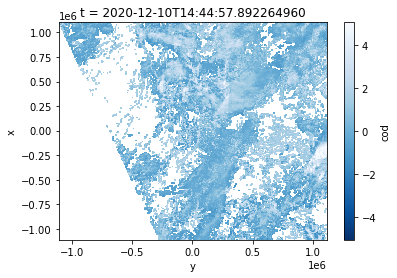

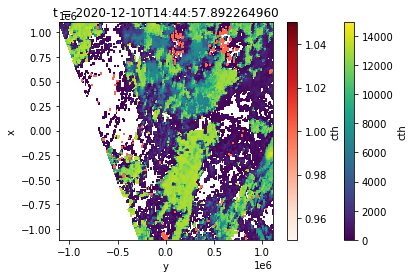

In [6]:
np.log(ds.isel(t = 20).cod).plot(cmap = cm.Blues_r)
plt.show()
ds.isel(t = 20).cth.plot()
(ds.cth < 20).where(ds.cth < 20).isel(t = 20).plot(cmap = cm.Reds)


### Animate cloud types and show advection for a couple of pixels

In [7]:
# pixel path

def nextLoc(ds, s, i, j
           ):
    """
    Function which determines the next location for a pixel at (k, i, j)
    t[k], x[i], y[j]
    returns new indices
    """
    
    t1 = ds.t[k] 
    x = ds.x[i]
    y = ds.y[j]

    dt = ds.t[k+1] - t1

    dt = (ds.t[k+1].data - t1.data ) 

    dx = ds.u[k,i,j].data * dt / np.timedelta64(1, 's') # m
    dy = ds.v[k,i,j].data * dt / np.timedelta64(1, 's') # m

    x_new = x - dy
    y_new = y - dx

    # First, find the index of the grid point nearest a specific lat/lon.   
    absx = np.abs(ds.x-x_new)
    absy = np.abs(ds.y-y_new)
    c = np.maximum(absx, absy)

    ([xloc], [yloc]) = np.where(c == np.min(c))

    
    return  xloc,yloc


i, j = [50, 50, 50, 150, 150, 150, 250, 250, 250, 350, 350, 350], 4 * [50, 150, 250]
i_start, j_start = [50, 50, 50, 150, 150, 150, 250, 250, 250, 350, 350, 350], 4 * [50, 150, 250]
x = np.zeros((ds.t.size, len(i)))
y = np.zeros((ds.t.size, len(i)))

x[0, :] = ds.x[i]
y[0, :] = ds.y[j]

xloc = np.zeros((ds.t.size, len(i)))
yloc = np.zeros((ds.t.size, len(i)))

xloc[0, :] = i
yloc[0, :] = j

for k in range(0, ds.t.size-1):
    for p in range(len(i)):
        print(k ,i[p], j[p], p , '           ', end = '\r')
        try:
            i[p], j[p] = md.nextLoc(ds, k, i[p], j[p])
        except ValueError:
            i[p], j[p] = i_start[p], j_start[p]
    x[k+1, :] = ds.x[i]
    y[k+1, :] = ds.y[j]
    xloc[k+1, :] = i
    yloc[k+1, :] = j



In [8]:
ds
grid_x, grid_y = np.meshgrid(ds.x, ds.y) # maybe find extent bit more precise


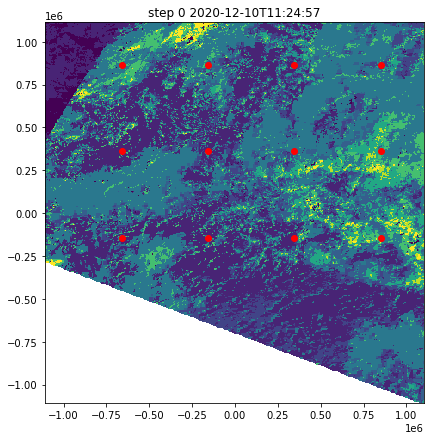

In [9]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)
# cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
norm = colors.Normalize(vmin=0, vmax=10)

def animate(i):
    ax.clear()
    ax.set_title(f'step {i} {ds.t[i].data.astype("datetime64[s]")}')
    plot = ax.pcolormesh(grid_x, grid_y, ds.ct[i,:,:].T, norm = norm)
    ax.plot(x[:i], y[:i], 'k')
    ax.scatter(x[i], y[i], color = 'r')
    ax.set_aspect('equal')
#     ax2.hist(ca.h[i,:,:].data.flatten())
#     cb = fig.colorbar(plot, ax = ax)
    return plot

# Create animation
ani = FuncAnimation(fig=fig, func=animate,
                    frames= range(ds.t.size), 
                    interval=500, repeat=True)

ani

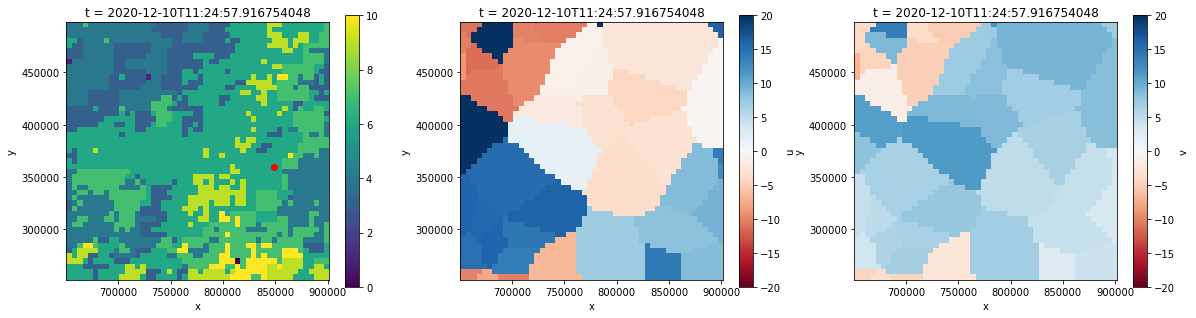

In [21]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

norm = colors.Normalize(vmin=0, vmax=10)
cb = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax)

norm2 = colors.Normalize(vmin=-20, vmax=20)
cb = fig.colorbar(cm.ScalarMappable(norm = norm2, cmap = cm.RdBu), ax=ax2, label = 'u')
cb = fig.colorbar(cm.ScalarMappable(norm = norm2, cmap = cm.RdBu), ax=ax3, label = 'v')

orig = [650e3, 250e3]
dx = 250e3

ds_zoom = ds.where((ds.x > orig[0]) & (ds.x < orig[0] + dx) & (ds.y > orig[1]) & (ds.y < orig[1] + dx) , drop = True)

def animate(i):
    ax.clear()
    ax2.clear()
    ax.set_title(f'step {i} {ds.t[i].data.astype("datetime64[s]")}')
#     plot = ax.pcolormesh(grid_x, grid_y, ds.ct[i,:,:].T, norm = norm)
    ds_zoom.ct.isel(t = i).plot(ax = ax, x = 'x', y = 'y', add_colorbar = False, norm = norm)
    ax.plot(x[:i], y[:i], 'k')
    ax.scatter(x[i], y[i], color = 'r')
    (ds_zoom.v.isel(t = i) * -1).plot(ax = ax2, x= 'x', y = 'y', add_colorbar = False, norm = norm2, cmap = cm.RdBu)
    (ds_zoom.u.isel(t = i) * -1).plot(ax = ax3, x= 'x', y = 'y', add_colorbar = False, norm = norm2, cmap = cm.RdBu)
    ax.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')
#     ax2.hist(ca.h[i,:,:].data.flatten())
#     cb = fig.colorbar(plot, ax = ax)
    return 

# Create animation
ani = FuncAnimation(fig=fig, func=animate,
                    frames= range(ds.t.size), 
                    interval=500,
                    repeat=True)

ani

39


<xarray.Dataset>
Dimensions:  (t: 39, x: 39, y: 39)
Coordinates:
  * x        (x) float64 8.488e+05 8.488e+05 8.437e+05 ... 6.881e+05 6.831e+05
  * y        (y) float64 3.597e+05 3.647e+05 3.647e+05 ... 4.099e+05 4.099e+05
  * t        (t) datetime64[ns] 2020-12-10T11:24:57.916754048 ... 2020-12-10T...
Data variables:
    cth      (t, x, y) float32 6.167e+03 6.167e+03 ... 1.256e+04 1.256e+04
    cod      (t, x, y) float32 13.88 13.85 13.85 13.85 ... 7.608 7.608 7.608
    ct       (t, x, y) float64 6.0 6.0 6.0 6.0 6.0 6.0 ... 7.0 7.0 7.0 7.0 7.0
    u        (t, x, y) float32 -6.573 -6.573 -6.573 ... 0.8688 0.8688 0.8688
    v        (t, x, y) float32 2.97 2.97 2.97 2.97 ... 7.017 7.017 7.017 7.017
Attributes:
    extent:   [-50. -30.  -5.  15.]

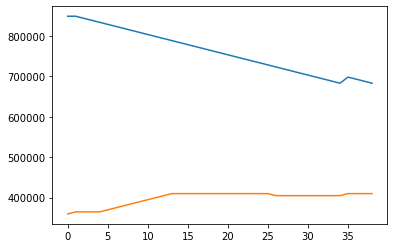

In [37]:
plt.plot(x[:,1])
plt.plot(y[:,1])
print(len(x))
d = {k:xr.DataArray(v, dims="pixel") for k, v in zip(list_of_coords_names, list_of_coords_values) }

ds.sel(x = x[:,1], y = y[:,1])

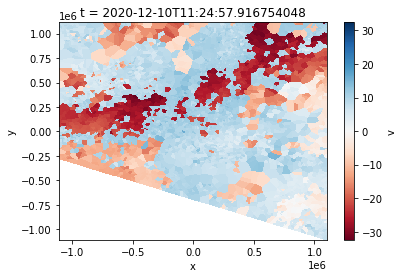

In [82]:
# ani.save('../fig/advectionOneDay.mp4')
ds.v.isel(t = 0).plot(x = 'x', y = 'y', cmap = cm.RdBu)

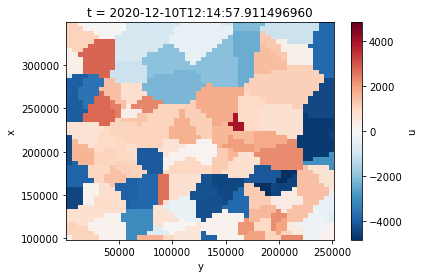

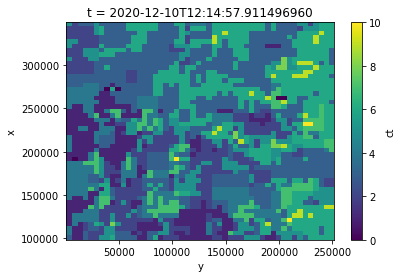

In [56]:
norm = colors.Normalize(vmin=0, vmax=10)

orig = [100e3, 0]
dx = 250e3

x = ds.where((ds.x > orig[0]) & (ds.x < orig[0] + dx) & (ds.y > orig[1]) & (ds.y < orig[1] + dx) , drop = True).isel(t = 5)
(x.u * 60 *10).plot()
plt.show()
x.ct.plot(norm = norm)


In [16]:
ct_adv = np.zeros((ds.t.size, len(j)))
ct_nonadv = np.zeros((ds.t.size, len(j)))
for i in range(ds.t.size):
#     print(i, xloc[i,p], yloc[i,p])
    for p in range(len(j)):
        ct_adv[i, p] = ds.ct[i, int(xloc[i, p]), int(yloc[i,p]) ]
        ct_nonadv[i,p] = ds.ct[i, int(xloc[0, p]), int(yloc[0,p]) ]

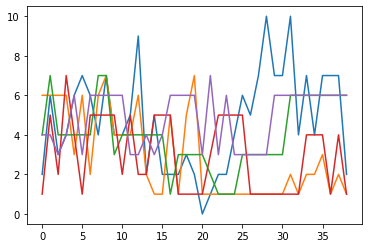

In [17]:
plt.plot(ct_adv[:,:5])

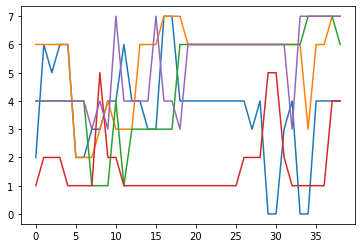

In [18]:
plt.plot(ct_nonadv[:,:5])

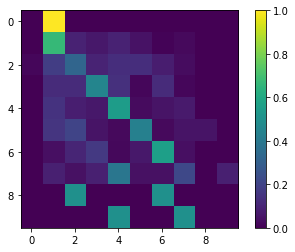

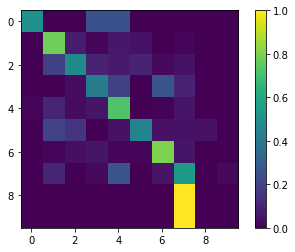

to    0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   10.0
from                                                            
0.0      2     0     0     1     1     0     0     0     0     0
1.0      0   110    11     2     9     7     0     2     0     0
2.0      0     8    20     4     3     4     1     2     0     0
3.0      0     0     1    13     6     0     8     3     0     0
4.0      2    11     3     6    77     0     1     6     0     0
5.0      0     4     3     0     1     9     1     1     1     0
6.0      0     1     3     4     1     1    57     4     0     0
7.0      0     4     0     1    10     0     2    21     0     1
8.0      0     0     0     0     0     0     0     1     0     0
10.0     0     0     0     0     0     0     0     1     0     0

In [19]:
import pandas as pd

def transitionMatrix(ct):
    df = pd.DataFrame(ct)
    nanrow = pd.DataFrame(np.nan * np.zeros((1,12)))
    to = df.append(nanrow)
    fr = nanrow.append(df)

    to = np.array(to).flatten()
    fr = np.array(fr).flatten()
    M = pd.crosstab(fr, to,
                        rownames = ['from'],
                        colnames = ['to'],
        #                 normalize = 'index'
                       )
    return M

def plotMnorm(M):
    M_norm = M.div(M.sum(axis=1), axis=0)
    plt.imshow(M_norm)
    plt.colorbar()

M_adv = transitionMatrix(ct_adv)
M_nonadv = transitionMatrix(ct_nonadv)

plotMnorm(M_adv)
plt.show()
plotMnorm(M_nonadv)
plt.show()
M_nonadv


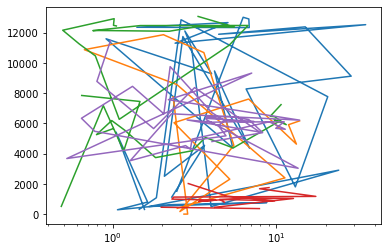

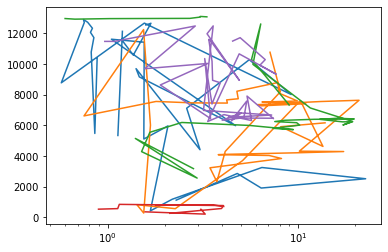

In [20]:
cth_adv = np.zeros((ds.t.size, len(j)))
cth_nonadv = np.zeros((ds.t.size, len(j)))
cod_adv = np.zeros((ds.t.size, len(j)))
cod_nonadv = np.zeros((ds.t.size, len(j)))
for i in range(ds.t.size):
#     print(i, xloc[i,p], yloc[i,p])
    for p in range(len(j)):
        cth_adv[i, p] = ds.cth[i, int(xloc[i, p]), int(yloc[i,p]) ]
        cth_nonadv[i,p] = ds.cth[i, int(xloc[0, p]), int(yloc[0,p]) ]
        cod_adv[i, p] = ds.cod[i, int(xloc[i, p]), int(yloc[i,p]) ]
        cod_nonadv[i,p] = ds.cod[i, int(xloc[0, p]), int(yloc[0,p]) ]

for p in range(5):
    plt.plot(cod_adv[:,p], cth_adv[:,p])
    plt.xscale('log')
plt.show()

for p in range(5):
    plt.plot(cod_nonadv[:,p], cth_nonadv[:,p])
    plt.xscale('log')
plt.show()

## check VAR(1) model

#### data set

In [21]:
print(xloc.shape, yloc.shape)
list(ds.data_vars)

(39, 12) (39, 12)


['cth', 'cod', 'ct', 'u', 'v']

In [22]:
N = len(j)  # number of tracked points

hoi = 1 # number of nan rows between different pixel paths. 

X = np.zeros(((ds.t.size + hoi) * len(j) , 3))
for i in range(ds.t.size + hoi ):
#     print(i, xloc[i,p], yloc[i,p])
    for p in range(len(j)):
        if i <ds.t.size:
#             X[(ds.t.size + hoi) * p + i, 2] = p
            X[(ds.t.size + hoi) * p + i, 0]  = ds.cth[i, int(xloc[i, p]), int(yloc[i,p]) ]
            X[(ds.t.size + hoi) * p + i, 1]  = ds.cod[i, int(xloc[i, p]), int(yloc[i,p]) ]
            X[(ds.t.size + hoi) * p + i, 2]  = ds.ct[i, int(xloc[i, p]), int(yloc[i,p]) ]
        else: 
            X[(ds.t.size + hoi) * p + i, :] = np.nan # add a nan row to seperate different days/pixels


df = pd.DataFrame(X,
                   columns=['h_t', 'd_t', 'ct'])

df.loc[df['ct'] == 1,['h_t', 'd_t']] = np.nan
# df.hist('ct')

df.loc[df['h_t'].isna(), 'd_t'] = np.nan
df.loc[df['d_t'].isna(), 'h_t'] = np.nan

df.d_t = np.log(df.d_t) #-> should add this in the data processing. 

# cloud to cloud

# filter cloud to cloud 
s_t = df[['h_t', 'd_t']].iloc[1:].reset_index(drop=True)
s_t1 = df[['h_t', 'd_t']].iloc[:-1].add_suffix('1')
df_s = pd.concat([s_t, s_t1], axis = 1).dropna()

mu = np.matrix(s_t.mean()).T  # -> stationairy
print(mu)

s_t = np.matrix(df_s[['h_t', 'd_t']]).T
s_t1 = np.matrix(df_s[['h_t1', 'd_t1']]).T


T = len(df_s)
D = np.zeros((2,2))
N = np.zeros((2,2))
for t in range(T):
    s_ttemp = s_t[:,t]
    s_t1temp = s_t1[:,t]
    tempD = s_t1temp @ s_t1temp.T
    tempN = s_ttemp @ s_t1temp.T
    D += tempD
    N += tempN

A = N @ np.linalg.inv(D)
print('A = ', A, '\n')

Z = s_t - A @ s_t1
Sigma = np.cov(Z)
print('Sigma = ', Sigma, '\n')

x_0 = s_t.mean(axis = 1)
x_0


[[5.52270339e+03]
 [8.89172040e-01]]
A =  [[8.67636541e-01 2.70937211e+02]
 [2.59261732e-05 6.99347028e-01]] 

Sigma =  [[1.07749529e+07 1.43832812e+02]
 [1.43832812e+02 7.09019524e-01]] 



matrix([[5.84829800e+03],
        [9.36267421e-01]])

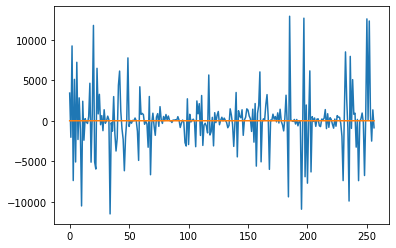

In [23]:
plt.plot((s_t - s_t1).T)

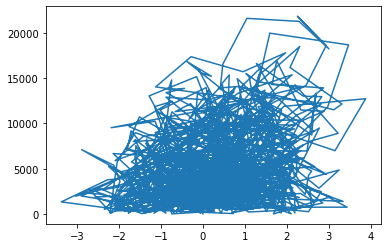

In [24]:
# simulation

T = 1000
x = np.zeros((T, 2))

Z = np.random.multivariate_normal([0,0], Sigma, size=T, check_valid='warn', tol=1e-8)

for t in range(T-1):
    x[t+1,:] = A @ x[t,:] + Z[t,:]
    x[t+1, 0] = np.abs(x[t+1,0])
s = np.array(x + mu.T).T
s = x.T
plt.plot(x[:,1], x[:,0])
# plt.plot(*s.mean(axis = 1), 'ro')
# plt.plot(*x_0.T,'o')


In [52]:
df['cloud'] = np.nan
df['cloud'].loc[df.ct > 1] = 1
df['cloud'].loc[df.ct == 1] = 0
df['next'] = np.roll(df.cloud,-1)
# filter cloud to cloud 

s_t = df.iloc[:-1].reset_index(drop=True)
s_t1 = df.iloc[1:].reset_index(drop = True).add_suffix('_next')
df_next = pd.concat([s_t, s_t1], axis = 1)


df_c = df.loc[(df.cloud == 1) & (df.next == 1)]
df_s = df_next.loc
df

h_t       d_t   ct  cloud  next
0     1126.812134  0.829726  2.0    1.0   1.0
1     4545.093750  1.291442  6.0    1.0   1.0
2     2504.806885  0.725430  3.0    1.0   1.0
3    11746.680664  0.986156  4.0    1.0   1.0
4     4360.140137  1.925494  6.0    1.0   1.0
..            ...       ...  ...    ...   ...
475           NaN       NaN  1.0    0.0   0.0
476           NaN       NaN  1.0    0.0   1.0
477           NaN       NaN  4.0    1.0   0.0
478           NaN       NaN  1.0    0.0   NaN
479           NaN       NaN  NaN    NaN   1.0

[480 rows x 5 columns]